<div style="text-align: center;">
    <h1>Plot everything in adiabatic showing hysteresis</h1>
</div>

Here, we plot $1-\langle \sigma_n^z\rangle$ and $\langle\Delta\sigma_n^z\Delta\sigma_{n+1}^z\rangle$, and $\langle\Delta\sigma_n^+\Delta\sigma_{n+1}^-\rangle$ which will be figure 3 in the PRL.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import time
from scipy.integrate import quad, solve_ivp
import os

We first define parameters

In [2]:
#define parameters
N = 40
J = 1
F = 0.5

#define variables for mu
mui = 0
muf = 5
dmu = 0.1

muArray = np.arange(mui,muf+dmu,dmu) # for numerical 
muAnal = np.arange(0, 5.02, 0.02) # for analytical

# For adiabatic
valTau = 1000
ti = 0
tf = valTau

<div style="text-align: center;">
    <h3>Sweepting detuning</h3>
</div>

First we read the simulation results

In [3]:
# Define the folder path
folder = f"output_avg_mu_N={N},alpha=0.001,F={F}"

# Initialize empty lists to store the data
density_mu = []
Sz_mu_correlation = []
SpSm_mu_correlation = []

print(f"Reading data from folder: {folder}")

# Start timing
start_time = time.time()

# Loop through the files from 1 to 51 (inclusive)
for mu in muArray: # Julia's 1:51 translates to Python's range(1, 52)
    filename = os.path.join(folder, f"output_N{N}_mu{mu:.1f}.txt")
    try:
        # Read the data from the file. 
        # Assuming each file contains 5 float numbers, one per line or space-separated on a single line.
        # If it's a single line of space-separated numbers, np.loadtxt will handle it.
        # If each number is on a new line, np.loadtxt also handles it by default.
        data = np.loadtxt(filename)
        
        # Check if the data has the expected length (5 elements)
        if len(data) == 3:
            # Append data to the respective lists (Python uses 0-based indexing)
            density_mu.append(data[0])
            Sz_mu_correlation.append(data[1])
            SpSm_mu_correlation.append(data[2])
        else:
            print(f"Warning: File {filename} does not contain 3 elements. Skipping.")

    except FileNotFoundError:
        print(f"Error: File not found at {filename}. Skipping.")
    except Exception as e:
        print(f"Error reading {filename}: {e}. Skipping.")

# End timing
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Finished reading data in {elapsed_time:.4f} seconds.")

Reading data from folder: output_avg_mu_N=40,alpha=0.001,F=0.5
Finished reading data in 0.0216 seconds.


First numerical for Sudden:

Now analytical for sweeping mu:

In [4]:
# Function to calculate the analytical density
def density_mu_analytical(mu: float, F: float) -> float:
    # Define the first integrand
    def integrand1(k):
        X = mu - 2 * np.cos(k)
        Y = 2 * F * np.sin(k)

        # Handle the singularity where X=0 and Y=0
        if X == 0 and Y == 0:
            return 0.0  # Define the integrand value at the singularity

        # Use atan2 for numerical stability for the angular terms
        # This is equivalent to Abs[X]/Sqrt[X^2+Y^2] * cos(k)
        # Note: abs(cos(atan(Y, X))) is equivalent to abs(X) / sqrt(X^2 + Y^2)
        return np.cos(np.arctan2(Y, X))

    # Perform the numerical integrations using QuadGK (scipy.integrate.quad in Python)
    integral1, _ = quad(integrand1, -np.pi, np.pi, epsabs=1e-8, epsrel=1e-8)
    
    # Calculate the final expression
    prefactor = (1 / (2 * np.pi))
    result = 1 - prefactor * integral1

    return result

# Function to calculate the analytical Sz correlation
def sz_mu_corr_analytical(mu: float, F: float) -> float:
    # Define the first integrand
    def integrand1(k):
        X = mu - 2 * np.cos(k)
        Y = 2 * F * np.sin(k)

        # Handle the singularity where X=0 and Y=0
        if X == 0 and Y == 0:
            return 0.0  # Define the integrand value at the singularity

        # Use atan2 for numerical stability for the angular terms
        # This is equivalent to Abs[X]/Sqrt[X^2+Y^2] * cos(k)
        # Note: abs(cos(atan(Y, X))) is equivalent to abs(X) / sqrt(X^2 + Y^2)
        return np.cos(np.arctan2(Y, X)) * np.cos(k)

    # Define the second integrand
    def integrand2(k):
        X = mu - 2 * np.cos(k)
        Y = 2 * F * np.sin(k)

        # Handle the singularity where X=0 and Y=0
        if X == 0 and Y == 0:
            return 0.0  # Define the integrand value at the singularity

        # This is equivalent to (Y / Sqrt[X^2+Y^2]) * Sign[X] * Sin[k]
        # Note: sin(atan(Y, X)) is equivalent to Y / sqrt(X^2 + Y^2)
        return np.sin(np.arctan2(Y, X)) * np.sin(k)

    # Perform the numerical integrations using QuadGK (scipy.integrate.quad in Python)
    integral1, _ = quad(integrand1, -np.pi, np.pi, epsabs=1e-8, epsrel=1e-8)
    integral2, _ = quad(integrand2, -np.pi, np.pi, epsabs=1e-8, epsrel=1e-8)

    # Calculate the final expression
    prefactor = (1 / (2 * np.pi))**2
    result = prefactor * (- (integral1)**2 + (integral2)**2)

    return result

def SpSm_mu_corr_analytical(mu: float, F: float) -> float:
    # Define the first integrand
    def integrand1(k):
        X = mu - 2 * np.cos(k)
        Y = 2 * F * np.sin(k)

        # Handle the singularity where X=0 and Y=0
        if X == 0 and Y == 0:
            return 0.0  # Define the integrand value at the singularity

        # Use atan2 for numerical stability for the angular terms
        # This is equivalent to Abs[X]/Sqrt[X^2+Y^2] * cos(k)
        # Note: abs(cos(atan(Y, X))) is equivalent to abs(X) / sqrt(X^2 + Y^2)
        return np.cos(np.arctan2(Y, X)) * np.cos(k)

    # Perform the numerical integrations using QuadGK (scipy.integrate.quad in Python)
    integral1, _ = quad(integrand1, -np.pi, np.pi, epsabs=1e-8, epsrel=1e-8)

    # Calculate the final expression
    prefactor = 1 / (4 * np.pi)
    result = prefactor * integral1

    return result

In [5]:
# Create arrays from the analytical functions
density_mu_anal = np.array([density_mu_analytical(m, F) for m in muAnal])
Sz_mu_corr_anal = np.array([sz_mu_corr_analytical(m, F) for m in muAnal])
SpSm_mu_corr_anal = np.array([SpSm_mu_corr_analytical(m, F) for m in muAnal])

Plotting:

In [6]:
# Define colors for each quantity, with a darker shade for analytical (solid)
# and a lighter shade for MPS (dashed with markers)
color_density_mu_anal = '#1a609d'  # Darker blue for Analytical Density
color_density_mu_mps = '#4682B4'   # SteelBlue for MPS Density

color_sz_mu_anal = '#A04000'       # Darker orange/brown for Analytical Sz
color_sz_mu_mps = '#FF7F0E'        # Original orange for MPS Sz

#color_spsm_mu_anal = '#006400'     # DarkGreen for Analytical SpSm
#color_spsm_mu_mps = '#2ca02c'      # Original green for MPS SpSm

color_spsm_mu_anal = '#00008B'     # DarkGreen for Analytical SpSm
color_spsm_mu_mps = '#4682B4'      # Original green for MPS SpSm

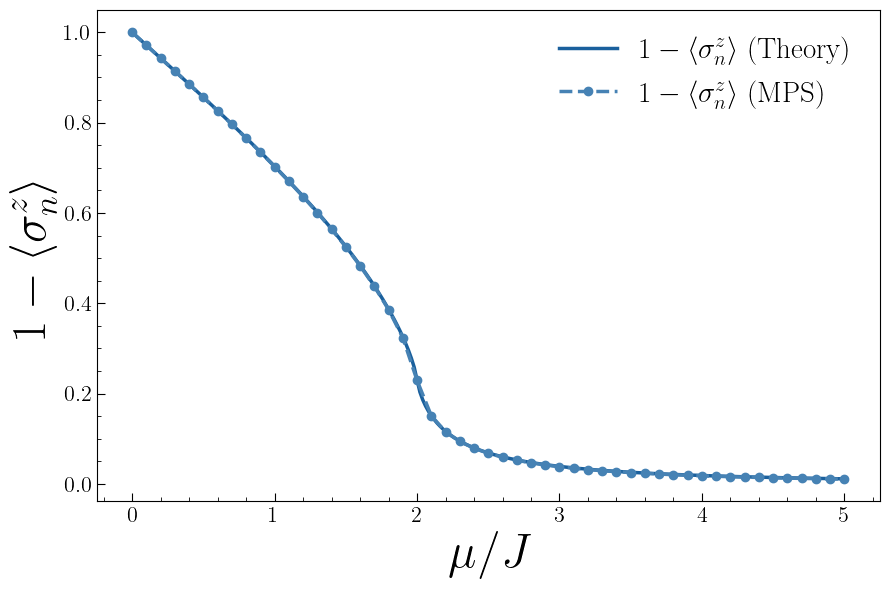

In [7]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(9, 6))


# A single color for the unified Y-axis label and ticks
unified_axis_color = 'black'

# Plotting Analytical results (solid lines, no markers, zorder=1)
ax1.plot(muAnal, density_mu_anal, color=color_density_mu_anal, linewidth=2.5, linestyle='solid', label=r'$1 - \langle \sigma_n^z \rangle$ (Theory)', zorder=1)

# Plotting MPS (Simulation) results (dashed lines, markers, zorder=2)
ax1.plot(muArray, density_mu, color=color_density_mu_mps, linewidth=2.5, linestyle='dashed', marker='o', markersize=6, label=r'$1 - \langle \sigma_n^z \rangle$ (MPS)', zorder=2)

# Set X-axis label
ax1.set_xlabel(r'$\mu/J$', fontsize=35)

# Set Y-axis label
ax1.set_ylabel(r'$1 - \langle \sigma_n^z \rangle$', color=unified_axis_color, fontsize=35)

# Apply tick parameters from the example
ax1.tick_params(axis='y', labelcolor=unified_axis_color)
ax1.tick_params(axis='both', which='major', direction='in', length=6, labelsize=16)
ax1.tick_params(axis='both', which='minor', direction='in', length=3, labelsize=16)

# Set minor tick locators
ax1.xaxis.set_minor_locator(AutoMinorLocator()) # Changed to AutoMinorLocator for general case
ax1.yaxis.set_minor_locator(AutoMinorLocator())

# Combine legends into a single legend for ax1
ax1.legend(loc='best', fontsize=21, frameon=False) # Use 'best' for automatic optimal placement

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# Save the figure
plt.savefig('density_mu.png', dpi=300, format='png', bbox_inches='tight')

# Show the plot
plt.show()


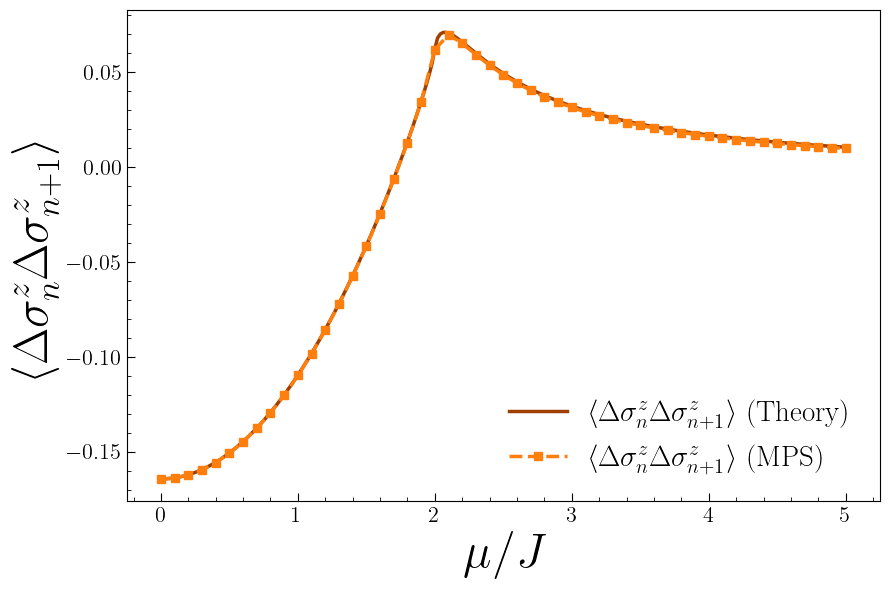

In [8]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(9, 6))

# A single color for the unified Y-axis label and ticks
unified_axis_color = 'black'

# Plotting Analytical results (solid lines, no markers, zorder=1)
ax1.plot(muAnal, Sz_mu_corr_anal, color=color_sz_mu_anal, linewidth=2.5, linestyle='solid', label=r'$\langle\Delta\sigma_n^z\Delta\sigma_{n+1}^z\rangle$ (Theory)', zorder=1)

# Plotting MPS (Simulation) results (dashed lines, markers, zorder=2)
ax1.plot(muArray, Sz_mu_correlation, color=color_sz_mu_mps, linewidth=2.5, linestyle='dashed', marker='s', markersize=6, label=r'$\langle\Delta\sigma_n^z\Delta\sigma_{n+1}^z\rangle$ (MPS)', zorder=2)

# Set X-axis label
ax1.set_xlabel(r'$\mu/J$', fontsize=35)

# Set Y-axis label
ax1.set_ylabel(r'$\langle\Delta\sigma_n^z\Delta\sigma_{n+1}^z\rangle$', color=unified_axis_color, fontsize=35)

# Apply tick parameters from the example
ax1.tick_params(axis='y', labelcolor=unified_axis_color)
ax1.tick_params(axis='both', which='major', direction='in', length=6, labelsize=16)
ax1.tick_params(axis='both', which='minor', direction='in', length=3, labelsize=16)

# Set minor tick locators
ax1.xaxis.set_minor_locator(AutoMinorLocator()) # Changed to AutoMinorLocator for general case
ax1.yaxis.set_minor_locator(AutoMinorLocator())

# Combine legends into a single legend for ax1
ax1.legend(loc='best', fontsize=21, frameon=False) # Use 'best' for automatic optimal placement

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# Save the figure
plt.savefig('Sz_mu_corr.png', dpi=300, format='png', bbox_inches='tight')

# Show the plot
plt.show()


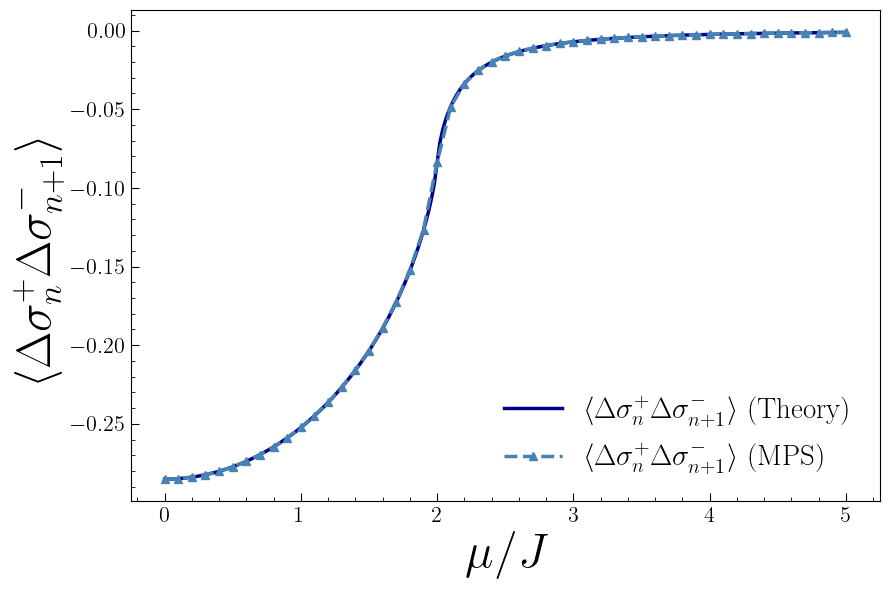

In [9]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(9, 6))

# A single color for the unified Y-axis label and ticks
unified_axis_color = 'black'

# Plotting Analytical results (solid lines, no markers, zorder=1)
ax1.plot(muAnal, SpSm_mu_corr_anal, color=color_spsm_mu_anal, linewidth=2.5, linestyle='solid', label=r'$\langle\Delta\sigma_n^+\Delta\sigma_{n+1}^-\rangle$ (Theory)', zorder=1)

# Plotting MPS (Simulation) results (dashed lines, markers, zorder=2)
ax1.plot(muArray, SpSm_mu_correlation, color=color_spsm_mu_mps, linewidth=2.5, linestyle='dashed', marker='^', markersize=6, label=r'$\langle\Delta\sigma_n^+\Delta\sigma_{n+1}^-\rangle$ (MPS)', zorder=2)

# Set X-axis label
ax1.set_xlabel(r'$\mu/J$', fontsize=35)

# Set Y-axis label
ax1.set_ylabel(r'$\langle\Delta\sigma_n^+\Delta\sigma_{n+1}^-\rangle$', color=unified_axis_color, fontsize=35)

# Apply tick parameters from the example
ax1.tick_params(axis='y', labelcolor=unified_axis_color)
ax1.tick_params(axis='both', which='major', direction='in', length=6, labelsize=16)
ax1.tick_params(axis='both', which='minor', direction='in', length=3, labelsize=16)

# Set minor tick locators
ax1.xaxis.set_minor_locator(AutoMinorLocator()) # Changed to AutoMinorLocator for general case
ax1.yaxis.set_minor_locator(AutoMinorLocator())

# Combine legends into a single legend for ax1
ax1.legend(loc='best', fontsize=21, frameon=False) # Use 'best' for automatic optimal placement

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# Save the figure
plt.savefig('SpSm_mu_corr.png', dpi=300, format='png', bbox_inches='tight')

# Show the plot
plt.show()


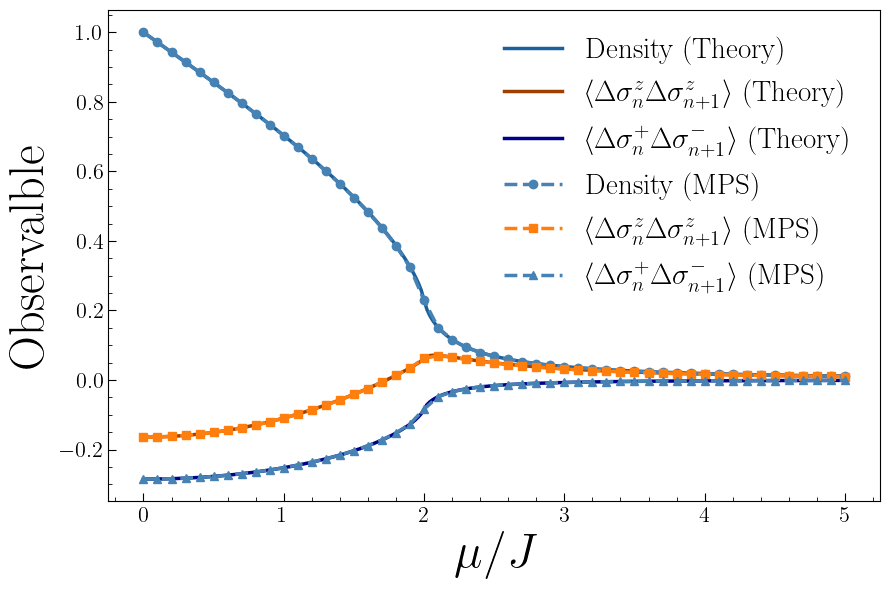

In [10]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(9, 6))


# A single color for the unified Y-axis label and ticks
unified_axis_color = 'black'

# Plotting Analytical results (solid lines, no markers, zorder=1)
ax1.plot(muAnal, density_mu_anal, color=color_density_mu_anal, linewidth=2.5, linestyle='solid', label='Density (Theory)', zorder=1)
ax1.plot(muAnal, Sz_mu_corr_anal, color=color_sz_mu_anal, linewidth=2.5, linestyle='solid', label=r'$\langle\Delta\sigma_n^z\Delta\sigma_{n+1}^z\rangle$ (Theory)', zorder=1)
ax1.plot(muAnal, SpSm_mu_corr_anal, color=color_spsm_mu_anal, linewidth=2.5, linestyle='solid', label=r'$\langle\Delta\sigma_n^+\Delta\sigma_{n+1}^-\rangle$ (Theory)', zorder=1)

# Plotting MPS (Simulation) results (dashed lines, markers, zorder=2)
ax1.plot(muArray, density_mu, color=color_density_mu_mps, linewidth=2.5, linestyle='dashed', marker='o', markersize=6, label='Density (MPS)', zorder=2)
ax1.plot(muArray, Sz_mu_correlation, color=color_sz_mu_mps, linewidth=2.5, linestyle='dashed', marker='s', markersize=6, label=r'$\langle\Delta\sigma_n^z\Delta\sigma_{n+1}^z\rangle$ (MPS)', zorder=2)
ax1.plot(muArray, SpSm_mu_correlation, color=color_spsm_mu_mps, linewidth=2.5, linestyle='dashed', marker='^', markersize=6, label=r'$\langle\Delta\sigma_n^+\Delta\sigma_{n+1}^-\rangle$ (MPS)', zorder=2)

# Set X-axis label
ax1.set_xlabel(r'$\mu/J$', fontsize=35)

# Set Y-axis label
ax1.set_ylabel('Observalble', color=unified_axis_color, fontsize=35)

# Apply tick parameters from the example
ax1.tick_params(axis='y', labelcolor=unified_axis_color)
ax1.tick_params(axis='both', which='major', direction='in', length=6, labelsize=16)
ax1.tick_params(axis='both', which='minor', direction='in', length=3, labelsize=16)

# Set minor tick locators
ax1.xaxis.set_minor_locator(AutoMinorLocator()) # Changed to AutoMinorLocator for general case
ax1.yaxis.set_minor_locator(AutoMinorLocator())

# Combine legends into a single legend for ax1
ax1.legend(loc='best', fontsize=21, frameon=False) # Use 'best' for automatic optimal placement

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# Save the figure
plt.savefig('combined_mu_results.png', dpi=300, format='png', bbox_inches='tight')

# Show the plot
plt.show()


<div style="text-align: center;">
    <h3>Switching on the drive at const mu</h3>
</div>

First, we read simulation results

In [11]:
# Define the folder path
folder = f"output_avg_N={N},alpha=0.001,F={F}"

# Initialize empty lists to store the data
density_F = []
Sz_F_correlation = []
SpSm_F_correlation = []

print(f"Reading data from folder: {folder}")

# Start timing
start_time = time.time()

# Loop through the files from 1 to 51 (inclusive)
for i in range(1,52): # Julia's 1:51 translates to Python's range(1, 51)
    filename = os.path.join(folder, f"output_for_N{N}_mu{i}.txt")
    try:
        # Read the data from the file. 
        # Assuming each file contains 5 float numbers, one per line or space-separated on a single line.
        # If it's a single line of space-separated numbers, np.loadtxt will handle it.
        # If each number is on a new line, np.loadtxt also handles it by default.
        data = np.loadtxt(filename)
        
        # Check if the data has the expected length (5 elements)
        if len(data) == 3:
            # Append data to the respective lists (Python uses 0-based indexing)
            density_F.append(data[0])
            Sz_F_correlation.append(data[1])
            SpSm_F_correlation.append(data[2])
        else:
            print(f"Warning: File {filename} does not contain 3 elements. Skipping.")

    except FileNotFoundError:
        print(f"Error: File not found at {filename}. Skipping.")
    except Exception as e:
        print(f"Error reading {filename}: {e}. Skipping.")

# End timing
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Finished reading data in {elapsed_time:.4f} seconds.")

Reading data from folder: output_avg_N=40,alpha=0.001,F=0.5
Finished reading data in 0.0186 seconds.


This is analytical for just switching the drive everywhere adiabatically

In [12]:
# Function to calculate the analytical density
def density_F_analytical(mu: float, F: float) -> float:
    # Define the first integrand
    def integrand1(k):
        X = mu - 2 * np.cos(k)
        Y = 2 * F * np.sin(k)

        # Handle the singularity where X=0 and Y=0
        if X == 0 and Y == 0:
            return 0.0  # Define the integrand value at the singularity

        # Use atan2 for numerical stability for the angular terms
        # This is equivalent to Abs[X]/Sqrt[X^2+Y^2] * cos(k)
        # Note: abs(cos(atan(Y, X))) is equivalent to abs(X) / sqrt(X^2 + Y^2)
        return abs(np.cos(np.arctan2(Y, X)))

    # Perform the numerical integrations using QuadGK (scipy.integrate.quad in Python)
    integral1, _ = quad(integrand1, -np.pi, np.pi, epsabs=1e-8, epsrel=1e-8)
    
    # Calculate the final expression
    prefactor = (1 / (2 * np.pi))
    result = 1 - prefactor * integral1

    return result

# Function to calculate the analytical Sz correlation
#def sz_corr_analytical(mu: float, F: float) -> float:
    # Define the first integrand
    def integrand1(k):
        X = mu - 2 * np.cos(k)
        Y = 2 * F * np.sin(k)

        # Handle the singularity where X=0 and Y=0
        if X == 0 and Y == 0:
            return 0.0  # Define the integrand value at the singularity

        # Use atan2 for numerical stability for the angular terms
        # This is equivalent to Abs[X]/Sqrt[X^2+Y^2] * cos(k)
        # Note: abs(cos(atan(Y, X))) is equivalent to abs(X) / sqrt(X^2 + Y^2)
        return abs(np.cos(np.arctan2(Y, X))) * np.cos(k)

    # Define the second integrand
    def integrand2(k):
        X = mu - 2 * np.cos(k)
        Y = 2 * F * np.sin(k)

        # Handle the singularity where X=0 and Y=0
        if X == 0 and Y == 0:
            return 0.0  # Define the integrand value at the singularity

        # This is equivalent to (Y / Sqrt[X^2+Y^2]) * Sign[X] * Sin[k]
        # Note: sin(atan(Y, X)) is equivalent to Y / sqrt(X^2 + Y^2)
        return np.sin(np.arctan2(Y, X)) * np.sign(X) * np.sin(k)

    # Perform the numerical integrations using QuadGK (scipy.integrate.quad in Python)
    integral1, _ = quad(integrand1, -np.pi, np.pi, epsabs=1e-8, epsrel=1e-8)
    integral2, _ = quad(integrand2, -np.pi, np.pi, epsabs=1e-8, epsrel=1e-8)

    # Calculate the final expression
    prefactor = (1 / (2 * np.pi))**2
    result = prefactor * (- (integral1)**2 + (integral2)**2)

    return result

# This is a modified version of the function to handle singularities and discontinuities (obtained using Gemini and never checked)
def sz_F_corr_analytical(mu: float, F: float) -> float:
    # Define the first integrand (no issues reported here, keep as is)
    def integrand1(k):
        X = mu - 2 * np.cos(k)
        Y = 2 * F * np.sin(k)
        # Handle the singularity where X=0 and Y=0
        if X == 0 and Y == 0:
            return 0.0
        return abs(np.cos(np.arctan2(Y, X))) * np.cos(k)

    # Define the second integrand (the problematic one)
    def integrand2(k):
        X = mu - 2 * np.cos(k)
        Y = 2 * F * np.sin(k)
        # Handle the singularity where X=0 and Y=0
        if X == 0 and Y == 0:
            return 0.0
        return np.sin(np.arctan2(Y, X)) * np.sign(X) * np.sin(k)

    # Perform the numerical integration for integrand1
    integral1, _ = quad(integrand1, -np.pi, np.pi, epsabs=1e-8, epsrel=1e-8)

    # --- Handle integrand2 by splitting the interval at discontinuities ---
    integral2_sum = 0.0
    
    # Find critical points where X = 0 (i.e., cos(k) = mu / 2)
    critical_k_values = []
    if -2 <= mu <= 2: # Discontinuities only occur if mu/2 is in [-1, 1]
        # arccos returns values in [0, pi]
        k_val = np.arccos(mu / 2)
        
        # Add the positive solution if it's not exactly 0 or pi
        if 0 < k_val < np.pi:
            critical_k_values.append(k_val)
            critical_k_values.append(-k_val) # Also add the negative solution
        elif k_val == 0: # Only k=0 is a critical point if mu=2
            critical_k_values.append(0.0)
        # If k_val == np.pi (mu=-2), -np.pi is already a boundary, no new internal point

    # Combine integration limits and critical points, sort, and remove duplicates
    # Ensure -np.pi and np.pi are always included as boundaries
    integration_points = sorted(list(set([-np.pi, np.pi] + critical_k_values)))

    # Integrate over each sub-interval
    for i in range(len(integration_points) - 1):
        a = integration_points[i]
        b = integration_points[i+1]
        
        # Only integrate if the interval has a non-zero length
        if b > a:
            sub_integral, _ = quad(integrand2, a, b, epsabs=1e-8, epsrel=1e-8)
            integral2_sum += sub_integral

    # Calculate the final expression
    prefactor = (1 / (2 * np.pi))**2
    result = prefactor * (- (integral1)**2 + (integral2_sum)**2)

    return result

def SpSm_F_corr_analytical(mu: float, F: float) -> float:
    # Define the first integrand
    def integrand1(k):
        X = mu - 2 * np.cos(k)
        Y = 2 * F * np.sin(k)

        # Handle the singularity where X=0 and Y=0
        if X == 0 and Y == 0:
            return 0.0  # Define the integrand value at the singularity

        # Use atan2 for numerical stability for the angular terms
        # This is equivalent to Abs[X]/Sqrt[X^2+Y^2] * cos(k)
        # Note: abs(cos(atan(Y, X))) is equivalent to abs(X) / sqrt(X^2 + Y^2)
        return abs(np.cos(np.arctan2(Y, X))) * np.cos(k)

    # Perform the numerical integrations using QuadGK (scipy.integrate.quad in Python)
    integral1, _ = quad(integrand1, -np.pi, np.pi, epsabs=1e-8, epsrel=1e-8)

    # Calculate the final expression
    prefactor = 1 / (4 * np.pi)
    result = prefactor * integral1

    return result

In [13]:
# Create arrays from the analytical functions
density_F_anal = np.array([density_F_analytical(m, F) for m in muAnal])
Sz_F_corr_anal = np.array([sz_F_corr_analytical(m, F) for m in muAnal])
SpSm_F_corr_anal = np.array([SpSm_F_corr_analytical(m, F) for m in muAnal])

Plotting:

In [14]:
# Define colors for each quantity, with a darker shade for analytical (solid)
# and a lighter shade for MPS (dashed with markers)
color_density_F_anal = "#003a6d"  # Darker blue for Analytical Density
color_density_F_mps = "#0087F5"   # SteelBlue for MPS Density

color_sz_F_anal = "#6B2D03"       # Darker orange/brown for Analytical Sz
color_sz_F_mps = "#AC5000"        # Original orange for MPS Sz

#color_spsm_F_anal = "#003900"     # DarkGreen for Analytical SpSm
#color_spsm_F_mps = "#008a00"      # Original green for MPS SpSm

color_spsm_F_anal = '#8B0000'      # DarkGreen for Analytical SpSm
color_spsm_F_mps = '#CD5C5C'       # Original green for MPS SpSm

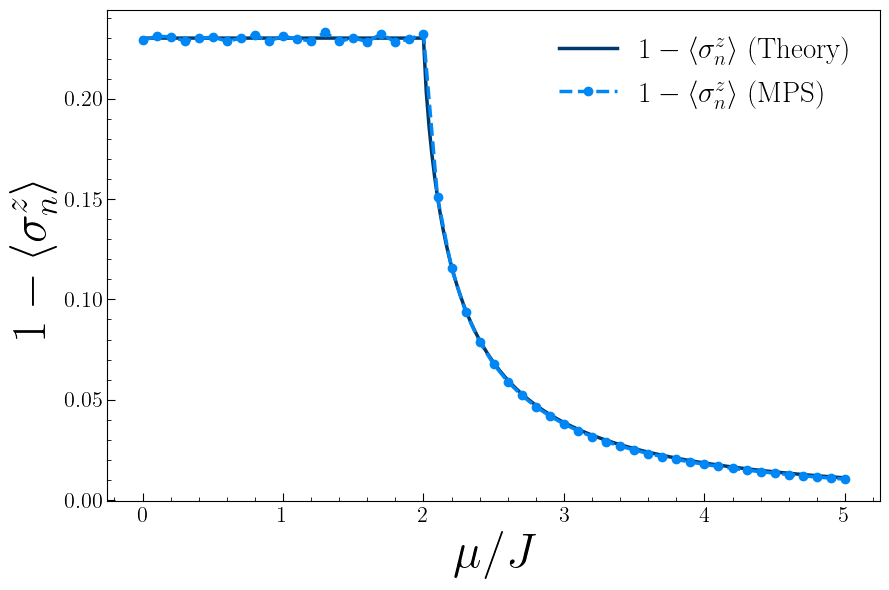

In [15]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(9, 6))


# A single color for the unified Y-axis label and ticks
unified_axis_color = 'black'

# Plotting Analytical results (solid lines, no markers, zorder=1)
ax1.plot(muAnal, density_F_anal, color=color_density_F_anal, linewidth=2.5, linestyle='solid', label=r'$1 - \langle \sigma_n^z \rangle$ (Theory)', zorder=1)

# Plotting MPS (Simulation) results (dashed lines, markers, zorder=2)
ax1.plot(muArray, density_F, color=color_density_F_mps, linewidth=2.5, linestyle='dashed', marker='o', markersize=6, label=r'$1 - \langle \sigma_n^z \rangle$ (MPS)', zorder=2)

# Set X-axis label
ax1.set_xlabel(r'$\mu/J$', fontsize=35)

# Set Y-axis label
ax1.set_ylabel(r'$1 - \langle \sigma_n^z \rangle$', color=unified_axis_color, fontsize=35)

# Apply tick parameters from the example
ax1.tick_params(axis='y', labelcolor=unified_axis_color)
ax1.tick_params(axis='both', which='major', direction='in', length=6, labelsize=16)
ax1.tick_params(axis='both', which='minor', direction='in', length=3, labelsize=16)

# Set minor tick locators
ax1.xaxis.set_minor_locator(AutoMinorLocator()) # Changed to AutoMinorLocator for general case
ax1.yaxis.set_minor_locator(AutoMinorLocator())

# Combine legends into a single legend for ax1
ax1.legend(loc='best', fontsize=21, frameon=False) # Use 'best' for automatic optimal placement

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# Save the figure
plt.savefig('density_F.png', dpi=300, format='png', bbox_inches='tight')

# Show the plot
plt.show()


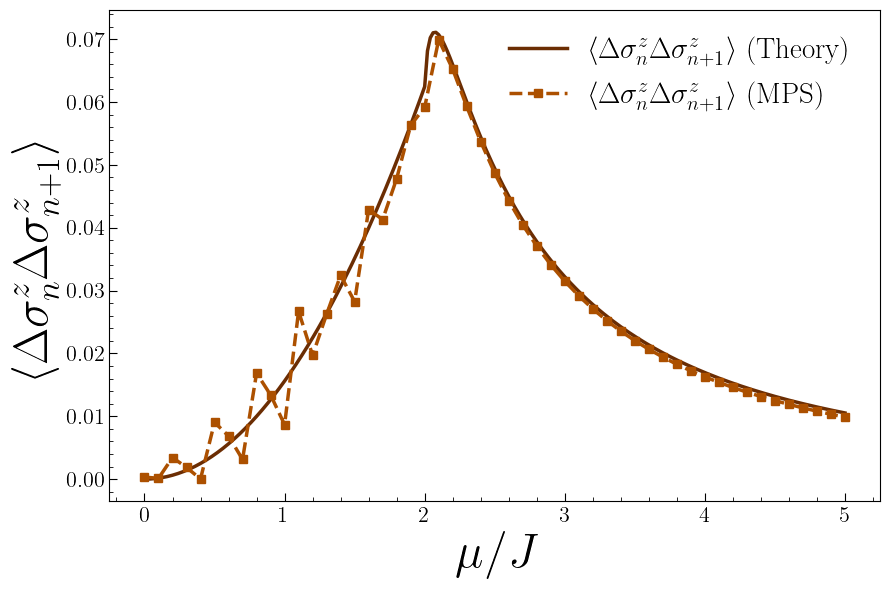

In [16]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(9, 6))

# A single color for the unified Y-axis label and ticks
unified_axis_color = 'black'

# Plotting Analytical results (solid lines, no markers, zorder=1)
ax1.plot(muAnal, Sz_F_corr_anal, color=color_sz_F_anal, linewidth=2.5, linestyle='solid', label=r'$\langle\Delta\sigma_n^z\Delta\sigma_{n+1}^z\rangle$ (Theory)', zorder=1)

# Plotting MPS (Simulation) results (dashed lines, markers, zorder=2)
ax1.plot(muArray, Sz_F_correlation, color=color_sz_F_mps, linewidth=2.5, linestyle='dashed', marker='s', markersize=6, label=r'$\langle\Delta\sigma_n^z\Delta\sigma_{n+1}^z\rangle$ (MPS)', zorder=2)

# Set X-axis label
ax1.set_xlabel(r'$\mu/J$', fontsize=35)

# Set Y-axis label
ax1.set_ylabel(r'$\langle\Delta\sigma_n^z\Delta\sigma_{n+1}^z\rangle$', color=unified_axis_color, fontsize=35)

# Apply tick parameters from the example
ax1.tick_params(axis='y', labelcolor=unified_axis_color)
ax1.tick_params(axis='both', which='major', direction='in', length=6, labelsize=16)
ax1.tick_params(axis='both', which='minor', direction='in', length=3, labelsize=16)

# Set minor tick locators
ax1.xaxis.set_minor_locator(AutoMinorLocator()) # Changed to AutoMinorLocator for general case
ax1.yaxis.set_minor_locator(AutoMinorLocator())

# Combine legends into a single legend for ax1
ax1.legend(loc='best', fontsize=21, frameon=False) # Use 'best' for automatic optimal placement

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# Save the figure
plt.savefig('Sz_F_corr.png', dpi=300, format='png', bbox_inches='tight')

# Show the plot
plt.show()


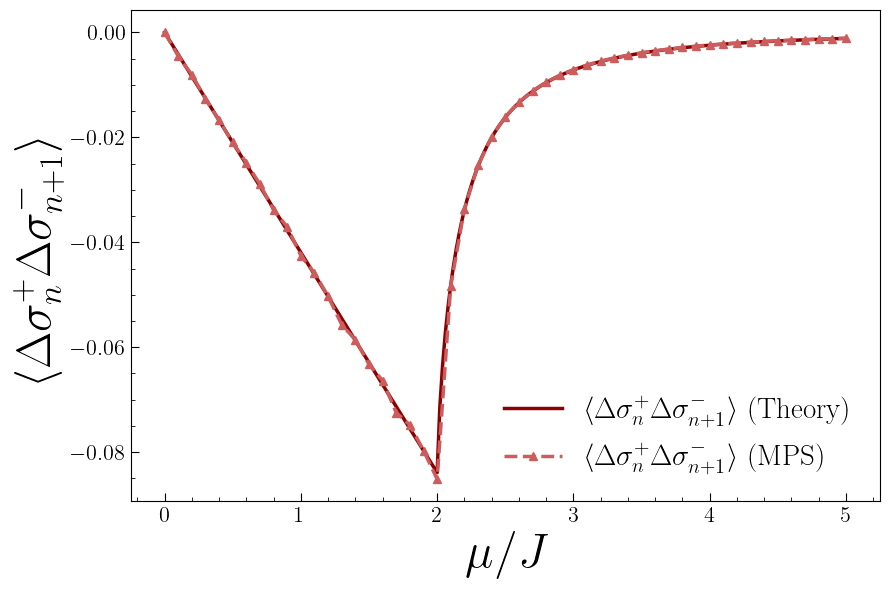

In [17]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(9, 6))

# A single color for the unified Y-axis label and ticks
unified_axis_color = 'black'

# Plotting Analytical results (solid lines, no markers, zorder=1)
ax1.plot(muAnal, SpSm_F_corr_anal, color=color_spsm_F_anal, linewidth=2.5, linestyle='solid', label=r'$\langle\Delta\sigma_n^+\Delta\sigma_{n+1}^-\rangle$ (Theory)', zorder=1)

# Plotting MPS (Simulation) results (dashed lines, markers, zorder=2)
ax1.plot(muArray, SpSm_F_correlation, color=color_spsm_F_mps, linewidth=2.5, linestyle='dashed', marker='^', markersize=6, label=r'$\langle\Delta\sigma_n^+\Delta\sigma_{n+1}^-\rangle$ (MPS)', zorder=2)

# Set X-axis label
ax1.set_xlabel(r'$\mu/J$', fontsize=35)

# Set Y-axis label
ax1.set_ylabel(r'$\langle\Delta\sigma_n^+\Delta\sigma_{n+1}^-\rangle$', color=unified_axis_color, fontsize=35)

# Apply tick parameters from the example
ax1.tick_params(axis='y', labelcolor=unified_axis_color)
ax1.tick_params(axis='both', which='major', direction='in', length=6, labelsize=16)
ax1.tick_params(axis='both', which='minor', direction='in', length=3, labelsize=16)

# Set minor tick locators
ax1.xaxis.set_minor_locator(AutoMinorLocator()) # Changed to AutoMinorLocator for general case
ax1.yaxis.set_minor_locator(AutoMinorLocator())

# Combine legends into a single legend for ax1
ax1.legend(loc='best', fontsize=21, frameon=False) # Use 'best' for automatic optimal placement

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# Save the figure
plt.savefig('SpSm_F_corr.png', dpi=300, format='png', bbox_inches='tight')

# Show the plot
plt.show()


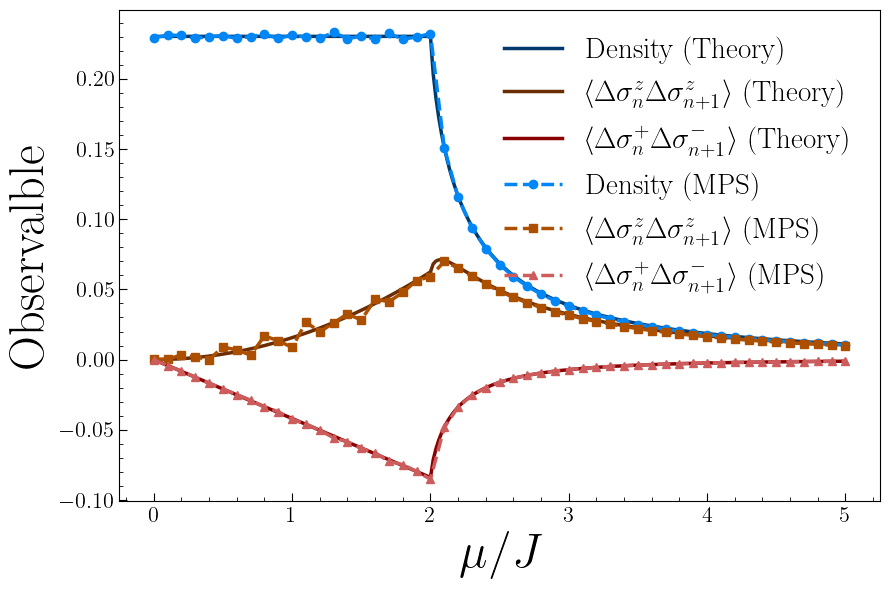

In [18]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(9, 6))


# A single color for the unified Y-axis label and ticks
unified_axis_color = 'black'

# Plotting Analytical results (solid lines, no markers, zorder=1)
ax1.plot(muAnal, density_F_anal, color=color_density_F_anal, linewidth=2.5, linestyle='solid', label='Density (Theory)', zorder=1)
ax1.plot(muAnal, Sz_F_corr_anal, color=color_sz_F_anal, linewidth=2.5, linestyle='solid', label=r'$\langle\Delta\sigma_n^z\Delta\sigma_{n+1}^z\rangle$ (Theory)', zorder=1)
ax1.plot(muAnal, SpSm_F_corr_anal, color=color_spsm_F_anal, linewidth=2.5, linestyle='solid', label=r'$\langle\Delta\sigma_n^+\Delta\sigma_{n+1}^-\rangle$ (Theory)', zorder=1)

# Plotting MPS (Simulation) results (dashed lines, markers, zorder=2)
ax1.plot(muArray, density_F, color=color_density_F_mps, linewidth=2.5, linestyle='dashed', marker='o', markersize=6, label='Density (MPS)', zorder=2)
ax1.plot(muArray, Sz_F_correlation, color=color_sz_F_mps, linewidth=2.5, linestyle='dashed', marker='s', markersize=6, label=r'$\langle\Delta\sigma_n^z\Delta\sigma_{n+1}^z\rangle$ (MPS)', zorder=2)
ax1.plot(muArray, SpSm_F_correlation, color=color_spsm_F_mps, linewidth=2.5, linestyle='dashed', marker='^', markersize=6, label=r'$\langle\Delta\sigma_n^+\Delta\sigma_{n+1}^-\rangle$ (MPS)', zorder=2)

# Set X-axis label
ax1.set_xlabel(r'$\mu/J$', fontsize=35)

# Set Y-axis label
ax1.set_ylabel('Observalble', color=unified_axis_color, fontsize=35)

# Apply tick parameters from the example
ax1.tick_params(axis='y', labelcolor=unified_axis_color)
ax1.tick_params(axis='both', which='major', direction='in', length=6, labelsize=16)
ax1.tick_params(axis='both', which='minor', direction='in', length=3, labelsize=16)

# Set minor tick locators
ax1.xaxis.set_minor_locator(AutoMinorLocator()) # Changed to AutoMinorLocator for general case
ax1.yaxis.set_minor_locator(AutoMinorLocator())

# Combine legends into a single legend for ax1
ax1.legend(loc='best', fontsize=21, frameon=False) # Use 'best' for automatic optimal placement

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# Save the figure
plt.savefig('combined_F_results.png', dpi=300, format='png', bbox_inches='tight')

# Show the plot
plt.show()


<div style="text-align: center;">
    <h3>Plot compiend results for hysteresis</h3>
</div>

In [19]:
# colors
color_mu_anal = '#8B0000'  # Darker blue for Analytical Density
color_mu_mps = '#CD5C5C'   # SteelBlue for MPS Density

color_F_anal = '#00008B'       # Darker orange/brown for Analytical Sz
color_F_mps = '#4682B4'        # Original orange for MPS Sz

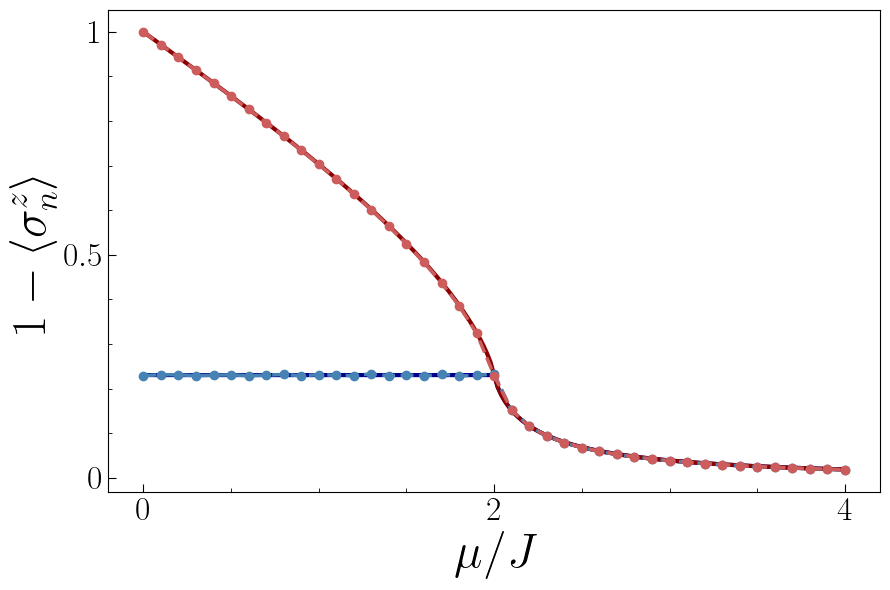

In [20]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(9, 6))


# A single color for the unified Y-axis label and ticks
unified_axis_color = 'black'

# Plotting Analytical results (solid lines, no markers, zorder=1)
ax1.plot(muAnal[0:201], density_F_anal[0:201], color=color_F_anal, linewidth=3, linestyle='solid', label=r'Sweep $F$ (Theory)', zorder=1)

# Plotting Analytical results (solid lines, no markers, zorder=1)
ax1.plot(muAnal[0:201], density_mu_anal[0:201], color=color_mu_anal, linewidth=3, linestyle='solid', label=r'Sweep $\mu$ (Theory)', zorder=1)

# Plotting MPS (Simulation) results (dashed lines, markers, zorder=2)
ax1.plot(muArray[0:41], density_F[0:41], color=color_F_mps, linewidth=2.5, linestyle='dashed', marker='o', markersize=6, label=r'Sweep $F$ (MPS)', zorder=2)


# Plotting MPS (Simulation) results (dashed lines, markers, zorder=2)
ax1.plot(muArray[0:41], density_mu[0:41], color=color_mu_mps, linewidth=2.5, linestyle='dashed', marker='o', markersize=6, label=r'Sweep $\mu$ (MPS)', zorder=2)

# Set X-axis label
ax1.set_xlabel(r'$\mu/J$', fontsize=35)

# Set Y-axis label
ax1.set_ylabel(r'$1 - \langle \sigma_n^z \rangle$', color=unified_axis_color, fontsize=35)

# Apply tick parameters from the example
ax1.tick_params(axis='y', labelcolor=unified_axis_color)
ax1.tick_params(axis='both', which='major', direction='in', length=6, labelsize=16)
ax1.tick_params(axis='both', which='minor', direction='in', length=3, labelsize=16)

ax1.set_xticks([0, 2, 4], labels=[r'$0$', r'$2$', r'$4$'], fontsize=24)
ax1.set_yticks([0, 0.5, 1], labels=[r'$0$', r'$0.5$', r'$1$'], fontsize=24)

# Set minor tick locators
ax1.xaxis.set_minor_locator(AutoMinorLocator()) # Changed to AutoMinorLocator for general case
ax1.yaxis.set_minor_locator(AutoMinorLocator())

# Combine legends into a single legend for ax1
#ax1.legend(loc='best', fontsize=21, frameon=False) # Use 'best' for automatic optimal placement

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# Save the figure
plt.savefig('density_hysteresis.png', dpi=300, format='png', bbox_inches='tight')

# Show the plot
plt.show()


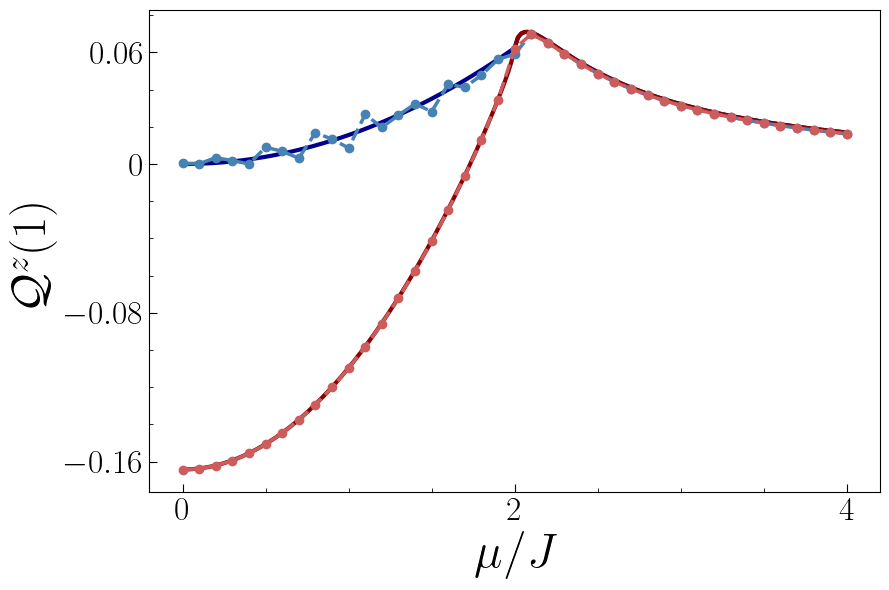

In [21]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(9, 6))

# A single color for the unified Y-axis label and ticks
unified_axis_color = 'black'

# Plotting Analytical results (solid lines, no markers, zorder=1)
ax1.plot(muAnal[0:201], Sz_F_corr_anal[0:201], color=color_F_anal, linewidth=3, linestyle='solid', label=r'Sweep $F$ (Theory)', zorder=1)

# Plotting Analytical results (solid lines, no markers, zorder=1)
ax1.plot(muAnal[0:201], Sz_mu_corr_anal[0:201], color=color_mu_anal, linewidth=3, linestyle='solid', label=r'Sweep $\mu$ (Theory)', zorder=1)

# Plotting MPS (Simulation) results (dashed lines, markers, zorder=2)
ax1.plot(muArray[0:41], Sz_F_correlation[0:41], color=color_F_mps, linewidth=2.5, linestyle='dashed', marker='o', markersize=6, label=r'Sweep $F$ (MPS)', zorder=2)

# Plotting MPS (Simulation) results (dashed lines, markers, zorder=2)
ax1.plot(muArray[0:41], Sz_mu_correlation[0:41], color=color_mu_mps, linewidth=2.5, linestyle='dashed', marker='o', markersize=6, label=r'Sweep $\mu$ (MPS)', zorder=2)



# Set X-axis label
ax1.set_xlabel(r'$\mu/J$', fontsize=35)

# Set Y-axis label
ax1.set_ylabel(r'$\mathcal{Q}^z(1)$', color=unified_axis_color, fontsize=35)

# Apply tick parameters from the example
ax1.tick_params(axis='y', labelcolor=unified_axis_color)
ax1.tick_params(axis='both', which='major', direction='in', length=6, labelsize=16)
ax1.tick_params(axis='both', which='minor', direction='in', length=3, labelsize=16)


ax1.set_xticks([0, 2, 4], labels=[r'$0$', r'$2$', r'$4$'], fontsize=24)
ax1.set_yticks([0.06,0, -0.08, -0.16], labels=[r'$0.06$',r'$0$', r'$-0.08$',r'$-0.16$'], fontsize=24)

# Set minor tick locators
ax1.xaxis.set_minor_locator(AutoMinorLocator()) # Changed to AutoMinorLocator for general case
ax1.yaxis.set_minor_locator(AutoMinorLocator())

# Combine legends into a single legend for ax1
#ax1.legend(loc='best', fontsize=21, frameon=False) # Use 'best' for automatic optimal placement

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# Save the figure
plt.savefig('Sz_hysteresis_corr.png', dpi=300, format='png', bbox_inches='tight')

# Show the plot
plt.show()


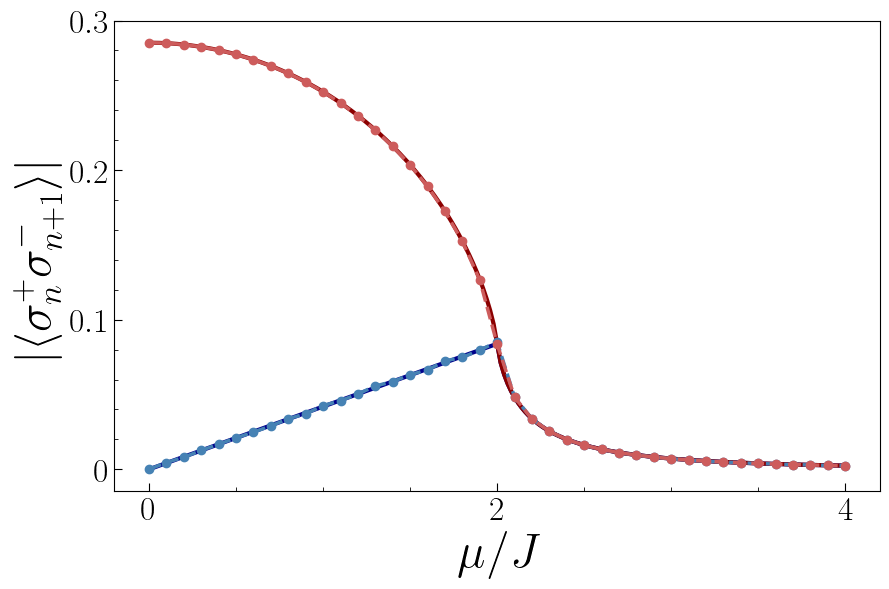

In [25]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

# Define the colors from the previous plot
color1 = '#4682B4'   # SteelBlue for dashed line (MPS)
dashed_color1 = '#00008B'   # Darker blue for solid line (Theory)
color2 = '#CD5C5C'   # IndianRed for dashed line (MPS)
dashed_color2 = '#8B0000'   # Darker red for solid line (Theory)
color1_axis_label = '#00008B' # Darker blue for axis label and ticks
color2_axis_label = '#8B0000' # Darker red for axis label and ticks

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(9, 6))

# A single color for the unified Y-axis label and ticks
unified_axis_color = "#000000"

# Plotting Analytical results (solid lines, no markers, zorder=1)
ax1.plot(muAnal[0:201], np.abs(SpSm_F_corr_anal[0:201]), color=dashed_color1, linewidth=3, linestyle='solid', label=r'Sweep $F$ (Theory)', zorder=1)

# Plotting Analytical results (solid lines, no markers, zorder=1)
ax1.plot(muAnal[0:201], np.abs(SpSm_mu_corr_anal[0:201]), color=dashed_color2, linewidth=3, linestyle='solid', label=r'Sweep $\mu$ (Theory)', zorder=1)

# Plotting MPS (Simulation) results (dashed lines, markers, zorder=2)
ax1.plot(muArray[0:41], np.abs(SpSm_F_correlation[0:41]), color=color1, linewidth=2.5, linestyle='dashed', marker='o', markersize=6, label=r'Sweep $F$ (MPS)', zorder=2)

# Plotting MPS (Simulation) results (dashed lines, markers, zorder=2)
ax1.plot(muArray[0:41], np.abs(SpSm_mu_correlation[0:41]), color=color2, linewidth=2.5, linestyle='dashed', marker='o', markersize=6, label=r'Sweep $\mu$ (MPS)', zorder=2)

# Set X-axis label
ax1.set_xlabel(r'$\mu/J$', fontsize=35)

# Set Y-axis label
ax1.set_ylabel(r'$|\langle\sigma_n^+\sigma_{n+1}^-\rangle|$', color=unified_axis_color, fontsize=35)

# Apply tick parameters from the example
ax1.tick_params(axis='y', labelcolor=unified_axis_color)
ax1.tick_params(axis='both', which='major', direction='in', length=6, labelsize=16)
ax1.tick_params(axis='both', which='minor', direction='in', length=3, labelsize=16)

ax1.set_xticks([0, 2, 4], labels=[r'$0$', r'$2$', r'$4$'], fontsize=24)
ax1.set_yticks([0, 0.1, 0.2, 0.3], labels=[r'$0$', r'$0.1$', r'$0.2$', r'$0.3$'], fontsize=24)

# Set minor tick locators
ax1.xaxis.set_minor_locator(AutoMinorLocator()) # Changed to AutoMinorLocator for general case
ax1.yaxis.set_minor_locator(AutoMinorLocator())

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# Save the figure
plt.savefig('SpSm_hysteresis_corr.png', dpi=300, format='png', bbox_inches='tight')

# Show the plot
plt.show()
